# Load Historical ENTSO-E data from their API

In [79]:
from entsoe import EntsoePandasClient
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
from keys import good_entsoe_keys
from pathlib import Path
import pytz
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
country_code = 'DE'
client = EntsoePandasClient(api_key=good_entsoe_keys[0])

In [22]:
end = pd.Timestamp(datetime.today())
start = pd.Timestamp(year=2015, month=5, day=1)

end = end.replace(tzinfo=timezone.utc)
start = start.replace(tzinfo=timezone.utc)

In [77]:
# How to aggregate data
TAGS_RENEW: dict[str, str] = {
    "Biomass": "Biomass",
    "Geothermal": "Geothermal",
    "Hydro_storage": "Hydro Pumped Storage",
    "Hydro": "Hydro Run-of-river and poundage",
    "Hydro_res": "Hydro Water Reservoir",
    "Other_renew": "Other renewable",
    "Solar": "Solar",
    "Wind_off": "Wind Offshore",
    "Wind_on": "Wind Onshore",
}

TAGS_NON_RENEW: dict[str, str] = {
    "Lignite": "Fossil Brown coal/Lignite",
    "Gas": "Fossil Gas",
    "Coal": "Fossil Hard coal",
    "Oil": "Fossil Oil",
    "Nuclear": "Nuclear",
    "Other": "Other",
    "Waste": "Waste",
}
ALL_TAGS: dict[str, str] = TAGS_NON_RENEW | TAGS_RENEW

# Query Generation

In [76]:
# this will take ~25 min. ~500000 rows of data by 32 columns
generation_raw: pd.DataFrame = client.query_generation(
    country_code=country_code, start=start, end=end)

KeyboardInterrupt: 

In [ ]:
# process
if isinstance(generation_raw.columns, pd.MultiIndex):
    generation_raw.columns = generation_raw.columns.droplevel(level=1)

# remove duplicated columns
generation_raw = generation_raw.loc[:, ~generation_raw.columns.duplicated()].copy()

# If the data is in 15-minute intervals, resample it to 1-hour intervals (for weather)
time_diff = generation_raw.index.to_series().diff().min()
if time_diff == pd.Timedelta(minutes=15):
    generation_raw = generation_raw.resample('h').mean()

# create a new data frame based on raw data
generation_processed: pd.DataFrame = pd.DataFrame(
    index=generation_raw.index,
    columns=ALL_TAGS.keys(),
)

# create a new data frame based on raw data
for k, v in ALL_TAGS.items():  # iterate over all production types
    # if the production type is not available, assume the production is 0
    if v in generation_raw.columns:
        generation_processed[k] = generation_raw[v]
    else:
        generation_processed[k] = 0.0
generation_processed = generation_processed.fillna(0.0)
generation_processed["Renewables"] = generation_processed[list(TAGS_RENEW)].sum(axis=1)
generation_processed["NonRenewables"] = generation_processed[list(TAGS_NON_RENEW)].sum(axis=1)
generation_processed["Total"] = generation_processed["NonRenewables"] + generation_processed["Renewables"]

generation_processed

# Query Load And Prices

In [ ]:
# Get load
load_raw: pd.DataFrame = client.query_load(
    country_code=country_code, start=start, end=end)

# If the data is in 15-minute intervals, resample it to 1-hour intervals (for weather)
time_diff = load_raw.index.to_series().diff().min()
if time_diff == pd.Timedelta(minutes=15):
    load_raw = load_raw.resample('h').mean()

load_raw

# Query Day-Ahead Prices
! For Germany there is no Bidding Zone 'DE'
- Before 2018 there was one called DE_AT_LU 
- After 2018 there was DE_LU

We get both, stich them and use as the one for DE

In [ ]:
# --- DE_AT_LU
prices_raw_de_at_lu: pd.DataFrame = client.query_day_ahead_prices(
    country_code='DE_AT_LU', start=start, end=end)
prices_raw_de_at_lu = prices_raw_de_at_lu.to_frame()
prices_raw_de_at_lu = prices_raw_de_at_lu.rename(columns={0: 'Day Ahead Price'})

# --- DE_LU
prices_raw_de_lu: pd.DataFrame = client.query_day_ahead_prices(
    country_code='DE_LU', start=start, end=end)
prices_raw_de_lu = prices_raw_de_lu.to_frame()
prices_raw_de_lu = prices_raw_de_lu.rename(columns={0: 'Day Ahead Price'})

# Combine
prices_raw = pd.concat([prices_raw_de_at_lu, prices_raw_de_lu], axis=0)


# Combine & Re-index

In [ ]:
data = pd.concat([generation_processed, load_raw, prices_raw], axis=1)

# Convert to UTC (use the same format as in weather data)
data = data.reset_index().rename(columns={"index":"date"})
data['datetime_utc'] = data['date'].dt.tz_convert('UTC')
data['dt_iso'] = data['datetime_utc'].dt.strftime("%Y-%m-%d %H:%M:%S %z UTC")
data.drop(labels=['datetime_utc','date'], axis=1, inplace=True)
data.dropna(inplace=True)

# Visualize

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


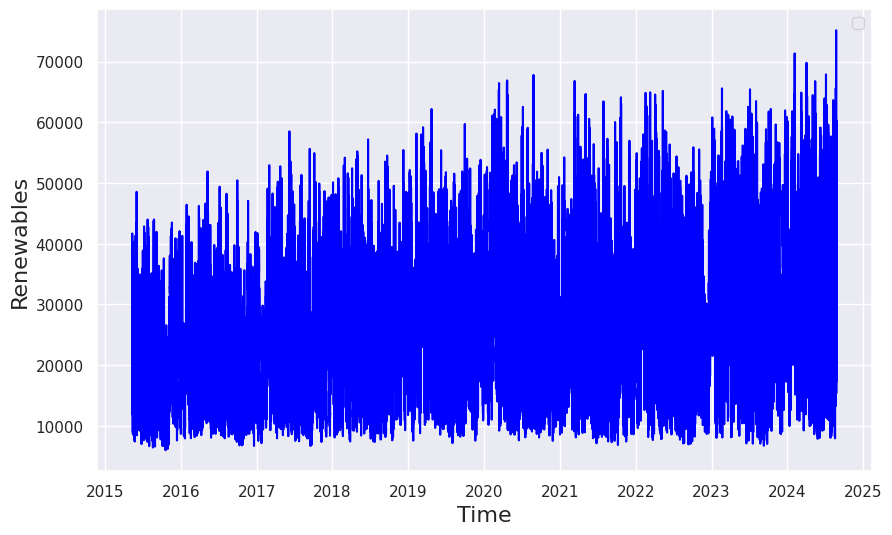

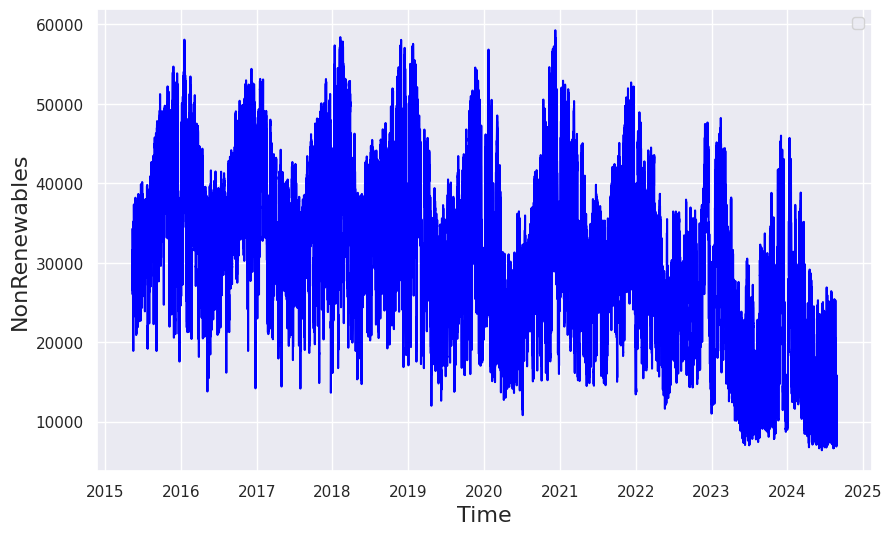

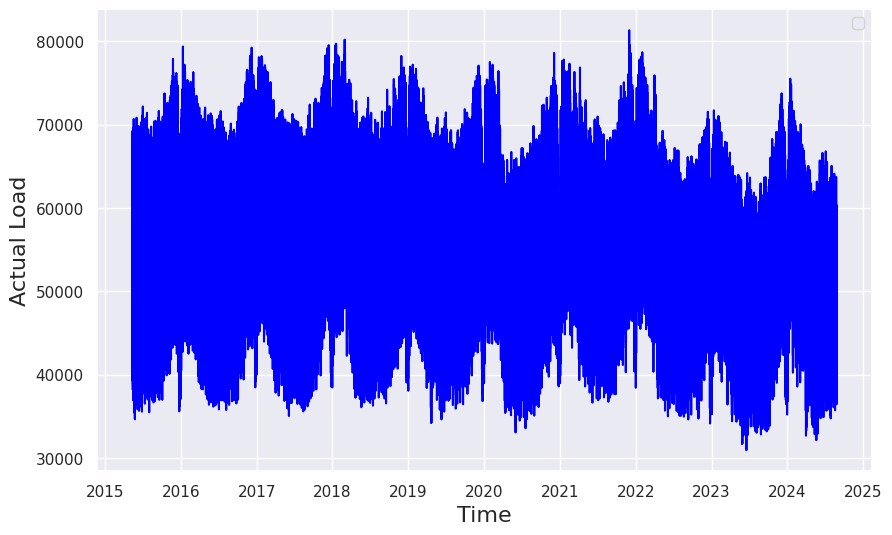

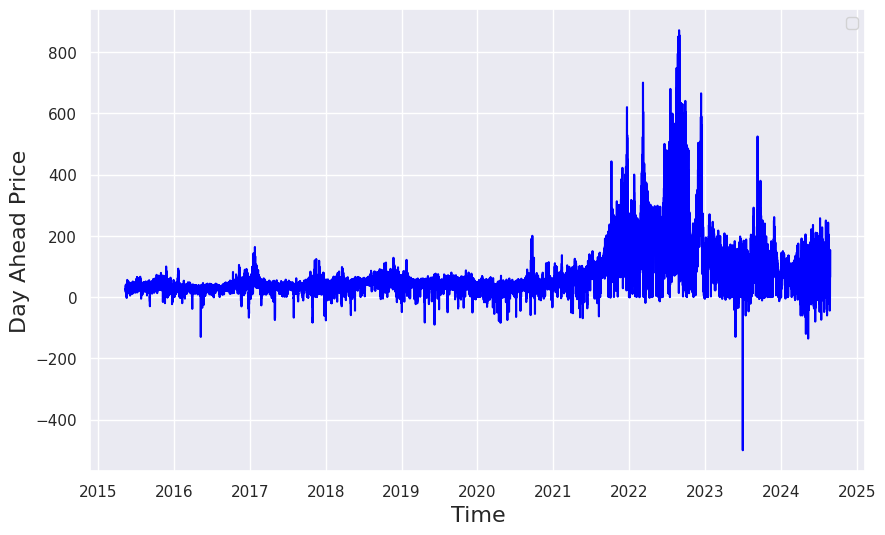

In [75]:
data_cp = data.copy(deep=True)

data_cp.index = pd.to_datetime(data['dt_iso'],format='%Y-%m-%d %H:%M:%S %z UTC')

def plot_series(ax,df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None,color=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    if color is None: color = 'black'
    sns.set()
    if ax is None: fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label, color=color)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label, color=color)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax


for key in ['Renewables','NonRenewables','Actual Load','Day Ahead Price']:
    ax = plot_series(None,data_cp,key,start=int(1*len(data_cp)/300),color='blue',ylabel=key)
    # plot_series(ax, data_cp, key, color='red',ylabel=key)
    ax.legend()
plt.show()

# Save historical data

In [81]:
timestr=time.strftime("%Y%m%d")
data.to_csv(Path().absolute() / 'data_original' / ('entsoe_gen_load_daprice_'+timestr+'.csv'),index=False)